In [1]:
# import openpyxl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential


In [2]:
#Copying current content to new editable directory
# !cp -r "../input/microsoft-catsvsdogs-dataset/PetImages/" "/kaggle/working/"

#Selecting dataset directory
ds_pet_dir = "./data"

#Generating a dataset
ds_pet = tf.keras.preprocessing.image_dataset_from_directory(ds_pet_dir)


Found 23472 files belonging to 3 classes.


In [3]:
#Listing directory. You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.
# !ls "/kaggle/working/PetImages/"
#Or
ds_pet.class_names


['Cat', 'Dog', 'cow']

In [4]:
#Checking images and labels shapes (amount of images, height, width, color channels)
for image_batch, labels_batch in ds_pet:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 256, 256, 3)
(32,)


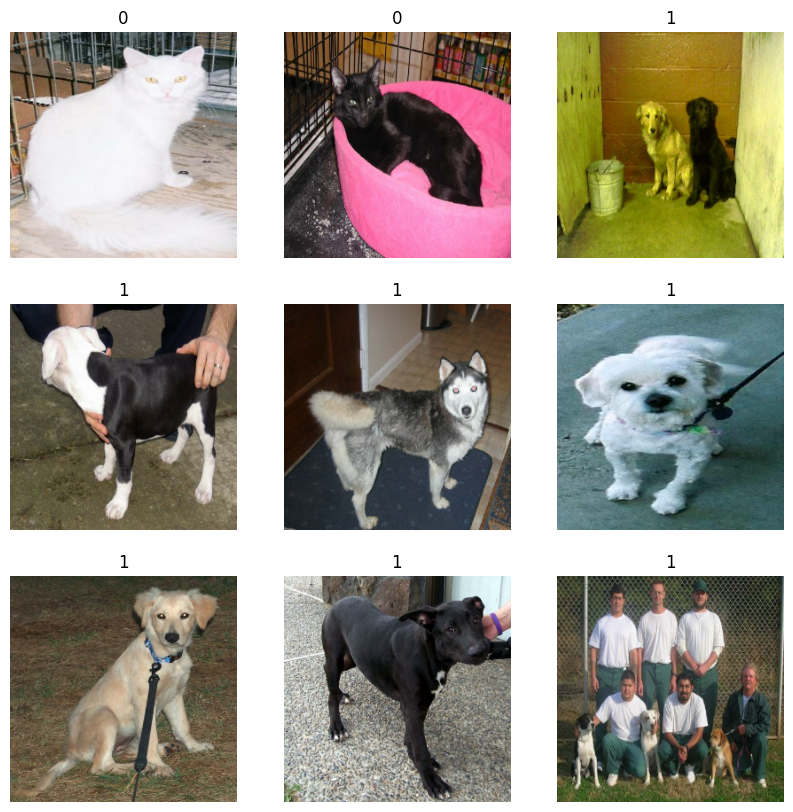

In [5]:
#Displaying image samples (label 0 is "cat" and label 1 is "dog")
plt.figure(figsize=(10, 10))
for images, labels in ds_pet.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


In [6]:
#Defining parameters for the loader:
batch_size = 32
img_height = 180
img_width = 180

#Filtering out corrupted images
import os
num_skipped = 0
for folder_name in ("Cat", "Dog","cow"):
    folder_path = os.path.join(ds_pet_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print("Deleted %d images" % num_skipped)

#Filtering out corrupted images

#Data augmentation
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)])

#Setting train/test split
ds_pet_train = tf.keras.preprocessing.image_dataset_from_directory(
    ds_pet_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=(img_height, img_width),
    batch_size=batch_size)
ds_pet_test = tf.keras.preprocessing.image_dataset_from_directory(
    ds_pet_dir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Deleted 0 images

Found 23472 files belonging to 3 classes.
Using 18778 files for training.
Found 23472 files belonging to 3 classes.
Using 4694 files for validation.


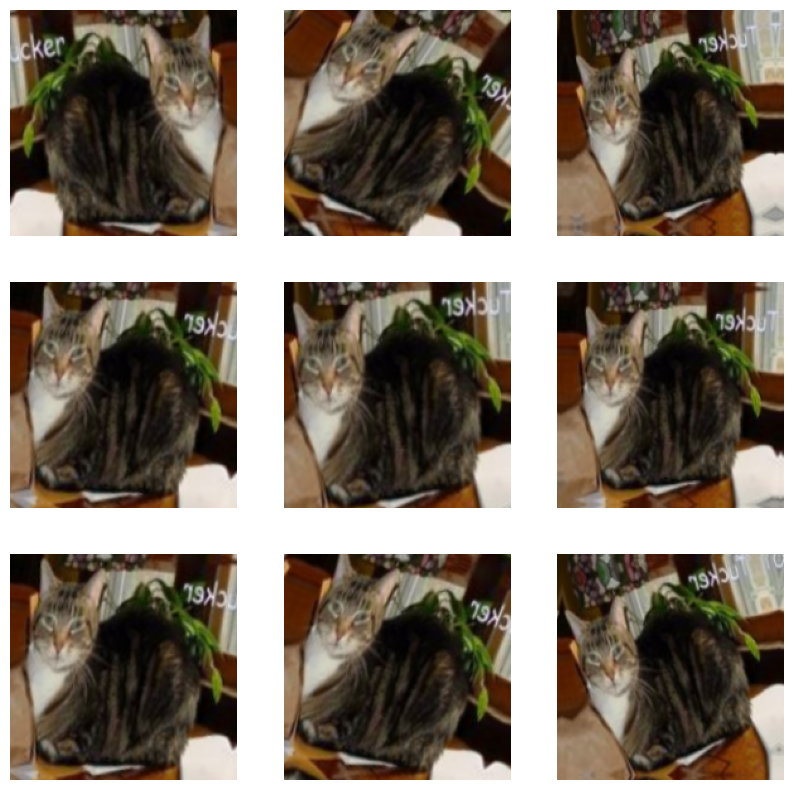

In [7]:
#Displaying a random augmented image sampled
plt.figure(figsize=(10, 10))
for images, _ in ds_pet_train.take(2):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [8]:
#Checking if the data format i.e the RGB channel is coming first or last so, whatever it may be, model will check first and then input shape will be feeded accordingly.
from keras import backend as K
if K.image_data_format() == "channels_first":
    input_shape = (3, img_height, img_width)
else:
    input_shape = (img_height, img_width, 3)

#Creating a model
model_dl = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(input_shape)),
  layers.Conv2D(16, 3, padding="same", activation="relu"),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding="same", activation="relu"),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding="same", activation="relu"),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation="relu"),
  layers.Dense(1, activation="sigmoid")
])


In [9]:
#Compiling the neural network
model_dl.compile(optimizer="Adam", loss="binary_crossentropy", metrics=["accuracy"])

#Fitting to the model
model_dl.fit(ds_pet_train, validation_data=ds_pet_test, epochs=1)





587/587 [==============================] - 460s 758ms/step - loss: 0.6832 - accuracy: 0.5725 - val_loss: 0.6329 - val_accuracy: 0.6496


In [10]:
#Saving the model
model_dl.save("model_dl2.h5")

#Loading themodel
model_dl = keras.models.load_model("model_dl2.h5") #look for local saved file
 

c:\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
#Using a random cat picture found in the web
picture_url = "data\Dog\4.jpg"
picture_path = tf.keras.utils.get_file("300", origin=picture_url)

img = keras.preprocessing.image.load_img(picture_path, target_size=(img_height, img_width))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model_dl.predict(img_array)
score = tf.nn.sigmoid(predictions[0])

print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(ds_pet.class_names[np.argmax(score)], 100 * np.max(score)))


1/1 [==============================] - 0s 176ms/step
This image most likely belongs to Cat with a 67.87 percent confidence.
